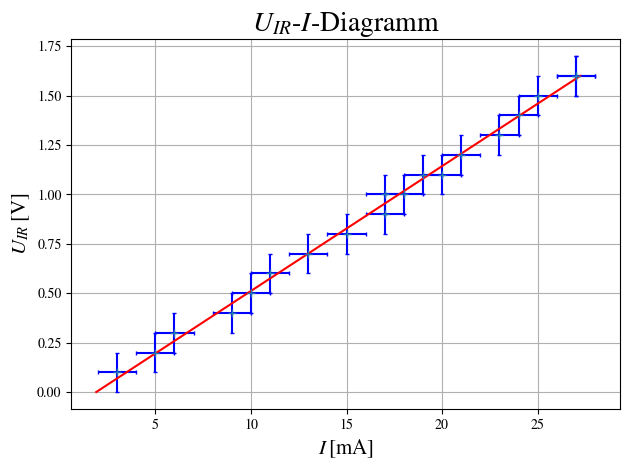

R=  63.20454925572839 +/- 4.575618874932944 b=  1.9097644879597793 +/- 0.22270855459789232
R_X  =  64.8439215901603 +/- 5.297690513507588


In [64]:
import sympy as sp
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
from tabulate import tabulate

import os
from os import listdir
from os.path import isfile, join

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

def calcErr(f: sp.Expr, values: List[float], errorL: List[float]) -> Tuple[sp.Function, float]:
    """
    Calculate error using Gaussian error propagation.
    
    Parameters:
    -----------
    f : sympy.Expr
        Symbolic function for which error needs to be calculated
    values : List[float]
        List of values for each variable in the function
    errorL : List[float]
        List of uncertainties for each variable in the function
        
    Returns:
    --------
    Tuple[sp.Function, float]
        - Symbolic error propagation function
        - Numerical result of error calculation
    """
    # Get variables in the function
    vars = list(f.free_symbols)
    
    if not (len(vars) == len(errorL) == len(values)):
        raise ValueError("Number of values and errors must match number of variables in function")
    
    # Create symbolic error variables
    error_symbols = [sp.Symbol(f'Δ{var}') for var in vars]
    
    # Create symbolic error propagation function
    error_expr = sp.sqrt(sum((sp.diff(f, var) * err)**2 
                           for var, err in zip(vars, error_symbols)))
    # Convert to sp.Function
    error_func = sp.Function('σ')(*error_symbols)
    
    error_func = error_func.subs(error_func, error_expr)
    
    # Print the symbolic error propagation function
    # print("\nSymbolic error propagation function:")
    # print(f"{error_func.simplify()}")
    
    # Calculate numerical result using the provided values
    numerical_error = error_expr.subs(dict(zip(error_symbols, errorL)))
    result = float(numerical_error.evalf(subs=dict(zip(vars, values))))
    

    return result

def find_error_func(f: sp.Expr) -> sp.Function:
    """
    Creates symbolic error propagation function for given function f.
    
    Parameters:
    -----------
    f : sympy.Expr
        Symbolic function for which error propagation function is needed
        
    Returns:
    --------
    sp.Function
        Symbolic error propagation function
    """
    # Get variables in the function
    vars = list(f.free_symbols)
    
    # Create symbolic error variables
    error_symbols = [sp.Symbol(f'Δ{var}') for var in vars]
    
    # Create symbolic error propagation function
    error_expr = sp.sqrt(sum((sp.diff(f, var) * err)**2 
                           for var, err in zip(vars, error_symbols)))
    
    # Convert to sp.Function
    error_func = sp.Function('σ')(*error_symbols)
    error_func = error_func.subs(error_func, error_expr)
    
    return error_func

def plot_table(columns, col_names, filename, title):
    """
    Plots a table from a list of numpy arrays (columns) and saves it as a PNG file.
    
    Parameters:
    columns (list of numpy.ndarray): The data to be plotted in the table, where each element is a column.
    col_names (list of str): The names of the columns.
    filename (str, optional): The name of the output PNG file.
    """
    # Get the maximum number of rows
    max_rows = max(len(col) for col in columns)
    
    # Create a 2D numpy array to hold the data
    data = np.full((max_rows, len(columns)), np.nan)
    
    # Fill the data array with the input columns
    for i, col in enumerate(columns):
        data[:len(col), i] = col
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(len(columns) * 1.5, max_rows * 0.5))
    ax.axis('tight')
    ax.axis('off')
    
    # Create the table
    the_table = ax.table(cellText=data.astype(str),
                        colLabels=col_names,
                        loc='center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(13)
    the_table.scale(1, 1.5)
    
    # Save the figure
    plt.title(title, fontsize=30)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)

def fit_error(x, x_err):

    y_err = len(x) / (np.sum(1/(x_err**2)))

    xsquaremean = np.average(x**2)
    xmean = np.average(x)
    yerrsquaremean = np.average(y_err)

    m_err = np.sqrt(yerrsquaremean / (len(x)*(xsquaremean - xmean**2)))
    n_err = np.sqrt((yerrsquaremean * xsquaremean) / (len(x) * (xsquaremean - xmean**2)))

    return m_err, n_err

def a():
    source = "Data/232a.csv"
    data = np.genfromtxt(source, delimiter=' ')
    voltage = data[:,1]
    amps = data[:,2]
    m, b = np.polyfit(voltage, amps, 1)

    

    x = np.linspace(0, np.max(voltage), 100)

    # Calculation

    x_errs = np.full(len(amps), 1)
    y_errs = np.full(len(voltage), 0.1)


    plt.errorbar(amps, voltage, marker='+', xerr=x_errs, yerr=y_errs, ls=' ', capsize=1.5, ecolor='blue')
    plt.plot(m*x + b, x, color='red')
    plt.ylabel(r'$U_{IR} \: \left[ \text{V} \right]$', fontsize=15)
    plt.xlabel(r'$I \: \left[ \text{mA} \right]$', fontsize=15)
    plt.title(r"$U_{IR}$-$I$-Diagramm", fontsize=20)
    plt.grid()
    plt.tight_layout()
    plt.show()

    m_si = m
    b_si = b

    m_err, b_err = fit_error(voltage, 0.1)
    
    print("R= ", 1000/m_si, "+/-", 1/m_err, "b= ", b_si, "+/-", b_err)



    R_U, R_A = sp.symbols('R_U R_A')
    R_X = (R_A * R_U) / (R_U - R_A)

    values = [2500, 1000/m_si]
    errors = [2500 * 0.01, 1.1/m_err]
    R_X_err = calcErr(R_X, values, errors)
    print("R_X  = ", R_X.evalf(subs={R_U:values[0], R_A:values[1]}) , "+/-", R_X_err)
a()
